In [130]:
import pandas as pd
import os
from pathlib import Path
from matplotlib import pyplot as plt
import sqlite3
import plotly.express as px
import plotly.graph_objects as go

In [2]:
# work from the project root
if os.getcwd().endswith('notebooks'):
    os.chdir("..")

In [112]:
outputs_root = Path('tfl_project/data/simulation_outputs')
dbpath = Path('tfl_project/data/bike_db.db')

In [185]:
def evaluate_sim(sim_id: str):
    df = pd.read_csv(outputs_root / sim_id / 'time_series.csv')
    ax = df.pivot_table(index='time', columns='sim_num').cumsum().stack(0).mean(axis=1).unstack().plot()
    stats = df.groupby('sim_num').sum().drop('time', axis=1)
    stats['combined_faults'] = stats['failed_starts'] + stats['failed_ends']
    stats = stats.agg(['mean','std','var','min','max'])
    return stats, ax

(      failed_starts   failed_ends  finished_journeys  combined_faults
 mean    2346.400000   3511.400000       28151.750000      5857.800000
 std       76.294030    214.245899         200.857340       195.518905
 var     5820.778947  45901.305263       40343.671053     38227.642105
 min     2225.000000   3073.000000       27773.000000      5511.000000,
 <matplotlib.axes._subplots.AxesSubplot at 0x13b2479b9c8>)

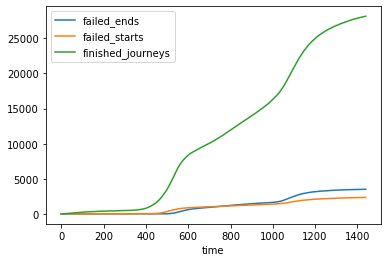

In [158]:
evaluate_sim('SIM_BASE_5AM_NO_REBAL')

(      failed_starts   failed_ends  finished_journeys  combined_faults
 mean    1506.850000   2980.500000       29063.500000      4487.350000
 std       82.183540    236.071466         164.851289       244.856838
 var     6754.134211  55729.736842       27175.947368     59954.871053
 min     1386.000000   2392.000000       28812.000000      3876.000000,
 <matplotlib.axes._subplots.AxesSubplot at 0x13b2469af48>)

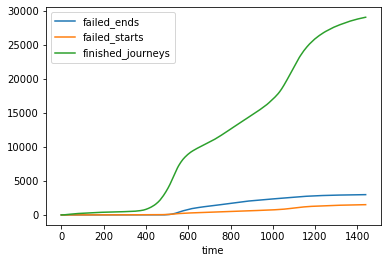

In [159]:
evaluate_sim('SIM_BIG_WAREHOUSE_5AM_NO_REBAL')

(      failed_starts  failed_ends  finished_journeys  combined_faults
 mean    2319.650000   637.300000       28156.550000      2956.950000
 std      103.838070    98.196420         145.085991       160.685202
 var    10782.344737  9642.536842       21049.944737     25819.734211
 min     2116.000000   491.000000       27898.000000      2685.000000,
 <matplotlib.axes._subplots.AxesSubplot at 0x13b2471de08>)

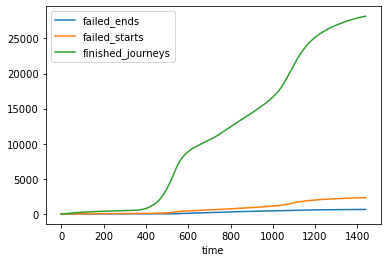

In [160]:
evaluate_sim('SIM_WH_CONSERV_ALLOC')

In [161]:
def mean_events_by_station(sim_id: str):

    df = pd.read_csv(outputs_root / sim_id / 'events.csv')
    # sumarise average destination events
    dests = df.groupby(['end_st','sim_num','event']).size() \
        .unstack('sim_num') \
        .mean(axis=1) \
        .unstack(fill_value=0) \
        .drop('failed_starts',1)

    # sumarise average origin events
    origins = df.groupby(['start_st','sim_num','event']).size() \
        .unstack('sim_num') \
        .mean(axis=1) \
        .unstack(fill_value=0) \
        .drop(['failed_ends', 'finished_journeys'],1)

    st_summ = pd.merge(dests, origins, left_index=True, right_index=True)
    st_summ.index.name = 'station'
    
    st_summ['combined_faults'] = st_summ['failed_ends'] + st_summ['failed_starts']
    st_summ['pct_failed_starts'] = 0
    st_summ['pct_failed_starts'].where(
            st_summ['combined_faults'] == 0
            ,st_summ['failed_starts'] / st_summ['combined_faults']
            ,inplace=True
    )
    
    return st_summ

In [162]:
def append_meta_data(df):
    db = sqlite3.connect(dbpath)
    query = ("SELECT bikepoint_id, common_name, latitude, longitude FROM station_metadata")
    metadata = pd.read_sql_query(query, db)
    df2 = pd.merge(df, metadata, left_index=True, right_on='bikepoint_id').drop('bikepoint_id',1)
    return df2

In [163]:
def plot_st_summ_map(df):
    
    fig = px.scatter_mapbox(
        data_frame=df
        ,lat='latitude'
        ,lon='longitude'
        ,hover_name ='common_name'
        ,size='combined_faults'
        ,color='pct_failed_starts'
        ,zoom=12
        #,=0.5
    )
    
    fig.update_geos(
        fitbounds='locations'
        ,projection_type='transverse mercator'
    )

    fig.update_layout(
        mapbox_style="carto-positron"
        #mapbox_style='dark'
    )

    return fig

In [164]:
def summ_and_plot_by_st(sim_id: str):
    st_summ = mean_events_by_station(sim_id)
    st_summ_2 = append_meta_data(st_summ)
    ax = plot_st_summ_map(st_summ_2)
    return st_summ, ax

## Wrap the evaluatins in one function:

In [180]:
def all_evals(sim_id: str):
    stats, ax1 = evaluate_sim(sim_id)
    st_summ, ax2 = summ_and_plot_by_st(sim_id)
    print()
    print(sim_id, '*'*50)
    print()
    print(stats)
    ax2.show()
    plt.show()
    


SIM_BASE_5AM_NO_REBAL **************************************************
      failed_starts   failed_ends  finished_journeys  combined_faults
mean    2346.400000   3511.400000       28151.750000      5857.800000
std       76.294030    214.245899         200.857340       195.518905
var     5820.778947  45901.305263       40343.671053     38227.642105
min     2225.000000   3073.000000       27773.000000      5511.000000
max     2514.000000   3808.000000       28561.000000      6120.000000


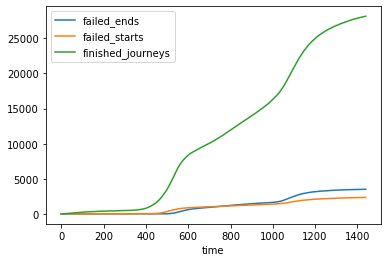


SIM_BIG_WAREHOUSE_5AM_NO_REBAL **************************************************
      failed_starts   failed_ends  finished_journeys  combined_faults
mean    1506.850000   2980.500000       29063.500000      4487.350000
std       82.183540    236.071466         164.851289       244.856838
var     6754.134211  55729.736842       27175.947368     59954.871053
min     1386.000000   2392.000000       28812.000000      3876.000000
max     1700.000000   3479.000000       29399.000000      4932.000000


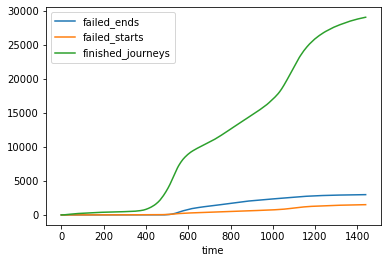


SIM_WH_SQUEEZED_ALLOC_V2 **************************************************
      failed_starts   failed_ends  finished_journeys  combined_faults
mean    1094.350000   2920.200000       29431.000000      4014.550000
std       80.190087    216.506375         185.795870       200.298586
var     6430.450000  46875.010526       34520.105263     40119.523684
min      957.000000   2551.000000       29064.000000      3704.000000
max     1235.000000   3320.000000       29726.000000      4423.000000


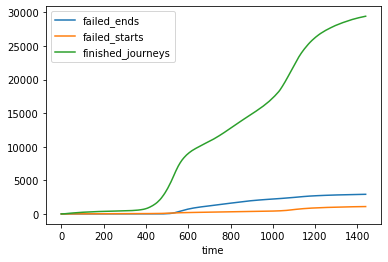


SIM_WH_CONSERV_ALLOC **************************************************
      failed_starts  failed_ends  finished_journeys  combined_faults
mean    2319.650000   637.300000       28156.550000      2956.950000
std      103.838070    98.196420         145.085991       160.685202
var    10782.344737  9642.536842       21049.944737     25819.734211
min     2116.000000   491.000000       27898.000000      2685.000000
max     2466.000000   847.000000       28407.000000      3242.000000


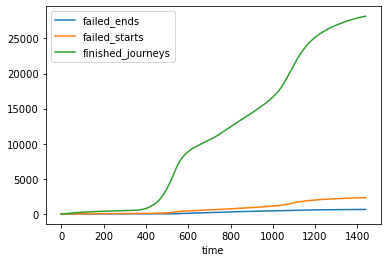


SIM_WH_CONSERV_ALLOC_V2 **************************************************
      failed_starts   failed_ends  finished_journeys  combined_faults
mean    1030.050000   1211.400000       29541.500000      2241.450000
std       63.962551    130.744186         164.678155       147.091978
var     4091.207895  17094.042105       27118.894737     21636.050000
min      907.000000   1010.000000       29198.000000      1988.000000
max     1128.000000   1435.000000       29850.000000      2507.000000


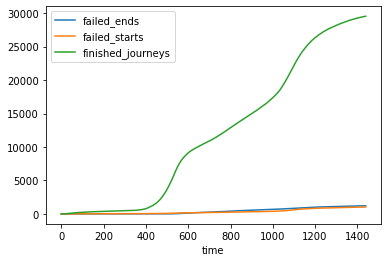

In [186]:
for sim_id in ['SIM_BASE_5AM_NO_REBAL', 'SIM_BIG_WAREHOUSE_5AM_NO_REBAL', 'SIM_WH_SQUEEZED_ALLOC_V2', 'SIM_WH_CONSERV_ALLOC', 'SIM_WH_CONSERV_ALLOC_V2']:
    all_evals(sim_id);